# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

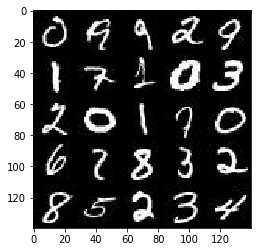

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

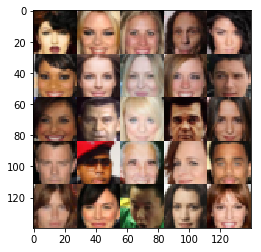

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
   
    with tf.variable_scope("discriminator", reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=not is_train):
        
        alpha=0.2 
        
        fc1 = tf.layers.dense(z, 7*7*512)
        
        
        x1 = tf.reshape(fc1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        print (x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 1, strides=1, padding='SAME')
        x2 = tf.layers.batch_normalization (x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        print (x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=2, padding ='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        print (x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=2, padding='SAME')
        
        out = tf.tanh(logits)
        print (logits)
        # expect 28
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tensor("Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 5), dtype=float32)
Tensor("Maximum_3:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("Maximum_4:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("Maximum_5:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("conv2d_transpose_6/BiasAdd:0", shape=(?, 28, 28, 5), dtype=float32)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha = 0.2
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-0.1)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tensor("generator/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 4), dtype=float32)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    steps = 0
    samples, losses = [], []
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                #_ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: x, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % 50 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    sample_z = np.random.uniform(-1, 1, size=(16, z_dim))
                    gen_samples = sess.run(
                                   generator(input_z, data_shape[3], is_train=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    # show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
                    show_generator_output(sess, 5, tf.convert_to_tensor(input_z), data_shape[3], data_image_mode)
                    #_ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    #plt.show()

        #saver.save(sess, './checkpoints/generator.ckpt')

    #with open('samples.pkl', 'wb') as f:
    #    pkl.dump(samples, f)
    
    return losses, samples
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Tensor("generator/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Epoch 1/2... Discriminator Loss: 0.8019... Generator Loss: 2.1073
Epoch 1/2... Discriminator Loss: 1.5388... Generator Loss: 0.4260
Tensor("generator_1/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_1/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_1/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_1/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_2/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_2/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_2/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_2/conv2d_transpose_3/BiasAdd:0", shape=(?, 

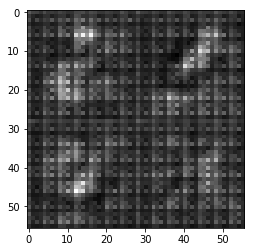

Epoch 1/2... Discriminator Loss: 0.5035... Generator Loss: 2.2739
Epoch 1/2... Discriminator Loss: 0.5197... Generator Loss: 2.3893
Tensor("generator_3/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_3/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_3/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_3/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_4/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_4/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_4/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_4/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


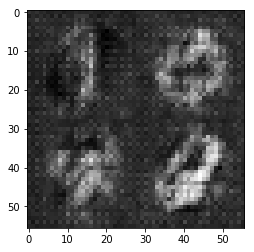

Epoch 1/2... Discriminator Loss: 1.0708... Generator Loss: 1.2742
Epoch 1/2... Discriminator Loss: 1.8766... Generator Loss: 0.3306
Tensor("generator_5/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_5/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_5/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_5/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_6/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_6/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_6/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_6/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


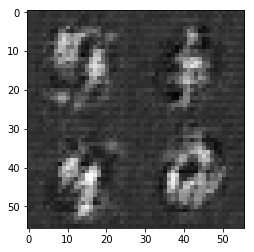

Epoch 1/2... Discriminator Loss: 1.2117... Generator Loss: 0.6639
Epoch 1/2... Discriminator Loss: 0.6718... Generator Loss: 1.5278
Tensor("generator_7/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_7/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_7/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_7/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_8/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_8/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_8/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_8/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


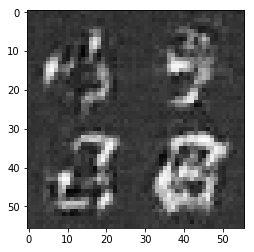

Epoch 1/2... Discriminator Loss: 0.5671... Generator Loss: 1.7343
Epoch 1/2... Discriminator Loss: 1.1977... Generator Loss: 0.6624
Tensor("generator_9/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_9/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_9/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_9/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_10/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_10/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_10/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_10/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


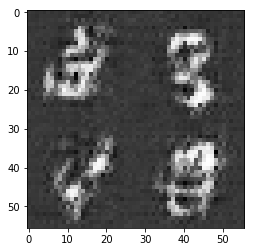

Epoch 1/2... Discriminator Loss: 1.1203... Generator Loss: 0.6831
Epoch 1/2... Discriminator Loss: 0.9382... Generator Loss: 0.9745
Tensor("generator_11/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_11/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_11/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_11/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_12/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_12/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_12/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_12/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


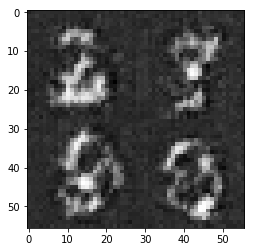

Epoch 1/2... Discriminator Loss: 0.5101... Generator Loss: 1.9681
Epoch 1/2... Discriminator Loss: 0.6156... Generator Loss: 1.5568
Tensor("generator_13/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_13/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_13/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_13/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_14/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_14/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_14/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_14/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


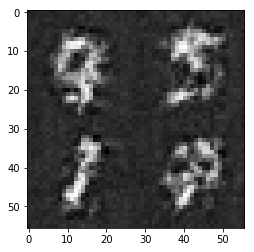

Epoch 1/2... Discriminator Loss: 0.4386... Generator Loss: 2.6910
Epoch 1/2... Discriminator Loss: 1.1301... Generator Loss: 0.7679
Tensor("generator_15/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_15/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_15/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_15/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_16/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_16/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_16/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_16/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


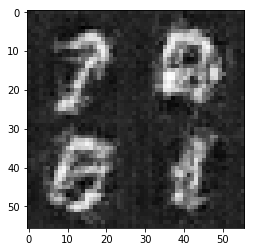

Epoch 1/2... Discriminator Loss: 0.5747... Generator Loss: 2.4929
Epoch 1/2... Discriminator Loss: 0.6696... Generator Loss: 1.4412
Tensor("generator_17/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_17/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_17/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_17/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_18/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_18/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_18/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_18/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


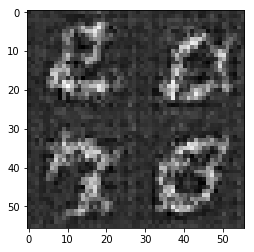

Epoch 1/2... Discriminator Loss: 0.4136... Generator Loss: 2.7055
Epoch 1/2... Discriminator Loss: 0.8394... Generator Loss: 1.0225
Tensor("generator_19/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_19/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_19/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_19/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_20/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_20/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_20/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_20/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


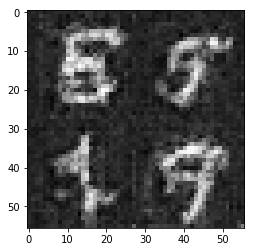

Epoch 1/2... Discriminator Loss: 0.4323... Generator Loss: 2.7690
Epoch 1/2... Discriminator Loss: 0.3483... Generator Loss: 4.6713
Tensor("generator_21/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_21/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_21/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_21/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_22/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_22/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_22/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_22/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


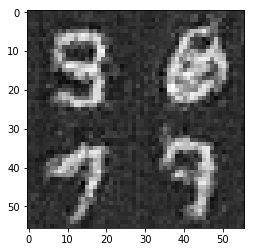

Epoch 1/2... Discriminator Loss: 0.5145... Generator Loss: 2.0709
Epoch 1/2... Discriminator Loss: 0.6491... Generator Loss: 1.4392
Tensor("generator_23/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_23/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_23/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_23/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_24/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_24/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_24/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_24/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


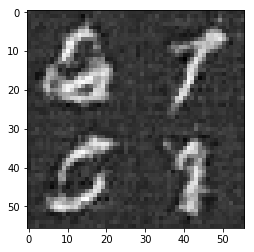

Epoch 1/2... Discriminator Loss: 0.4694... Generator Loss: 2.3319
Epoch 1/2... Discriminator Loss: 0.7519... Generator Loss: 1.3493
Tensor("generator_25/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_25/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_25/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_25/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_26/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_26/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_26/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_26/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


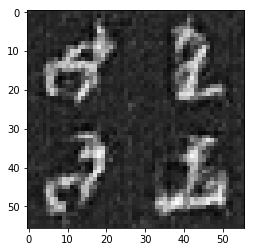

Epoch 1/2... Discriminator Loss: 0.9156... Generator Loss: 1.0622
Epoch 1/2... Discriminator Loss: 0.5601... Generator Loss: 1.8139
Tensor("generator_27/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_27/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_27/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_27/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_28/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_28/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_28/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_28/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


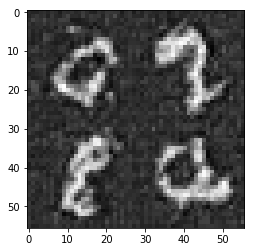

Epoch 1/2... Discriminator Loss: 0.4860... Generator Loss: 2.1294
Epoch 1/2... Discriminator Loss: 0.8100... Generator Loss: 3.0959
Tensor("generator_29/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_29/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_29/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_29/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_30/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_30/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_30/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_30/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


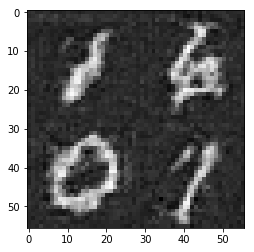

Epoch 1/2... Discriminator Loss: 1.0735... Generator Loss: 0.9194
Epoch 1/2... Discriminator Loss: 0.4164... Generator Loss: 2.6396
Tensor("generator_31/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_31/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_31/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_31/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_32/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_32/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_32/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_32/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


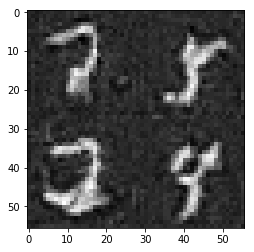

Epoch 1/2... Discriminator Loss: 0.5181... Generator Loss: 2.5532
Epoch 1/2... Discriminator Loss: 0.6206... Generator Loss: 1.5891
Tensor("generator_33/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_33/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_33/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_33/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_34/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_34/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_34/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_34/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


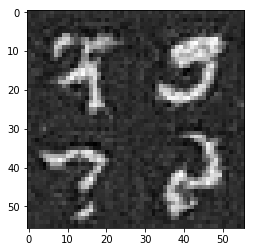

Epoch 1/2... Discriminator Loss: 1.1211... Generator Loss: 0.7965
Epoch 1/2... Discriminator Loss: 0.6013... Generator Loss: 1.9579
Tensor("generator_35/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_35/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_35/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_35/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_36/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_36/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_36/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_36/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


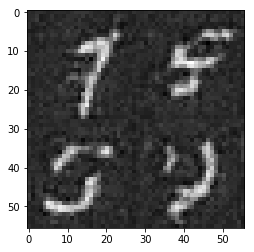

Epoch 1/2... Discriminator Loss: 0.5553... Generator Loss: 1.9576
Epoch 1/2... Discriminator Loss: 0.3991... Generator Loss: 2.9917
Tensor("generator_37/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_37/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_37/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_37/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_38/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_38/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_38/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_38/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


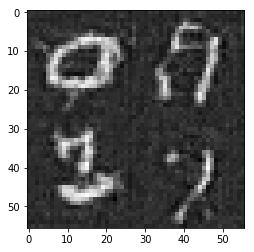

Epoch 1/2... Discriminator Loss: 2.5133... Generator Loss: 0.1900
Epoch 1/2... Discriminator Loss: 0.3578... Generator Loss: 3.8148
Tensor("generator_39/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_39/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_39/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_39/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_40/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_40/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_40/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_40/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


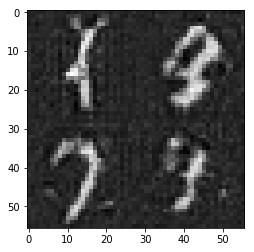

Epoch 1/2... Discriminator Loss: 0.4548... Generator Loss: 2.3313
Epoch 1/2... Discriminator Loss: 0.5763... Generator Loss: 2.6005
Tensor("generator_41/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_41/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_41/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_41/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_42/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_42/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_42/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_42/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


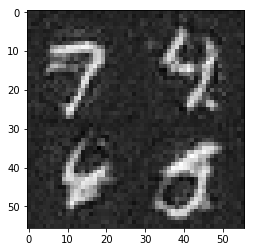

Epoch 1/2... Discriminator Loss: 0.4261... Generator Loss: 2.6247
Epoch 1/2... Discriminator Loss: 0.6279... Generator Loss: 1.9532
Tensor("generator_43/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_43/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_43/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_43/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_44/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_44/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_44/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_44/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


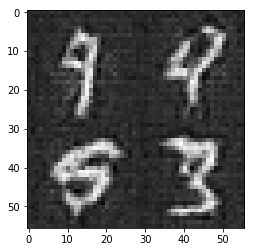

Epoch 1/2... Discriminator Loss: 0.6366... Generator Loss: 1.4571
Epoch 1/2... Discriminator Loss: 0.6484... Generator Loss: 1.5620
Tensor("generator_45/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_45/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_45/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_45/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_46/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_46/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_46/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_46/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


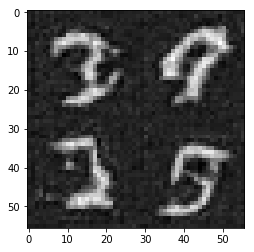

Epoch 1/2... Discriminator Loss: 0.4317... Generator Loss: 2.8390
Epoch 1/2... Discriminator Loss: 0.7140... Generator Loss: 1.3771
Tensor("generator_47/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_47/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_47/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_47/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_48/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_48/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_48/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_48/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


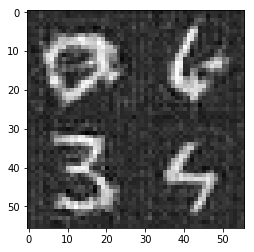

Epoch 1/2... Discriminator Loss: 0.6435... Generator Loss: 1.4657
Epoch 1/2... Discriminator Loss: 0.5291... Generator Loss: 2.3005
Tensor("generator_49/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_49/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_49/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_49/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_50/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_50/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_50/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_50/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


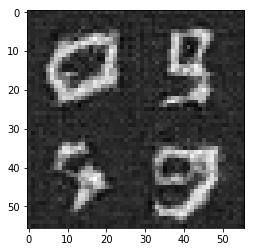

Epoch 1/2... Discriminator Loss: 0.4603... Generator Loss: 3.1793
Epoch 1/2... Discriminator Loss: 0.5862... Generator Loss: 1.7099
Tensor("generator_51/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_51/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_51/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_51/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_52/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_52/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_52/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_52/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


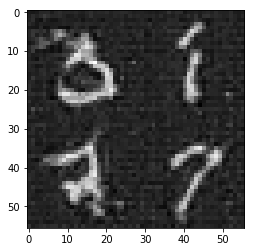

Epoch 1/2... Discriminator Loss: 0.6265... Generator Loss: 1.6045
Epoch 1/2... Discriminator Loss: 0.6090... Generator Loss: 1.8782
Tensor("generator_53/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_53/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_53/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_53/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_54/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_54/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_54/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_54/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


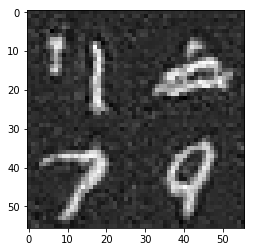

Epoch 1/2... Discriminator Loss: 1.4121... Generator Loss: 0.5341
Epoch 1/2... Discriminator Loss: 0.4932... Generator Loss: 2.1664
Tensor("generator_55/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_55/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_55/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_55/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_56/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_56/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_56/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_56/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


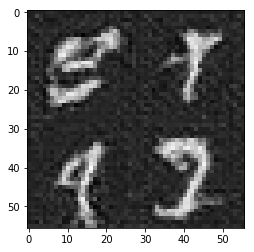

Epoch 1/2... Discriminator Loss: 0.5047... Generator Loss: 2.3469
Epoch 1/2... Discriminator Loss: 0.5216... Generator Loss: 1.9198
Tensor("generator_57/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_57/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_57/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_57/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_58/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_58/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_58/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_58/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


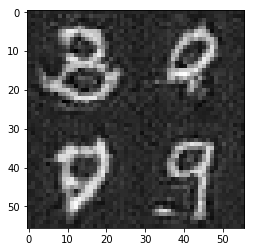

Epoch 1/2... Discriminator Loss: 1.0888... Generator Loss: 0.8492
Epoch 1/2... Discriminator Loss: 0.6555... Generator Loss: 1.4610
Tensor("generator_59/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_59/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_59/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_59/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_60/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_60/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_60/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_60/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


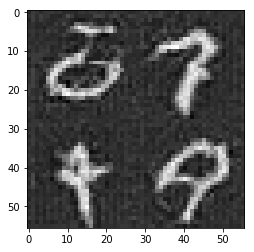

Epoch 1/2... Discriminator Loss: 0.4050... Generator Loss: 3.0198
Epoch 1/2... Discriminator Loss: 0.6805... Generator Loss: 2.0757
Tensor("generator_61/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_61/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_61/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_61/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_62/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_62/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_62/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_62/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


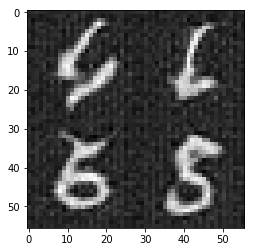

Epoch 1/2... Discriminator Loss: 0.4983... Generator Loss: 2.1698
Epoch 1/2... Discriminator Loss: 0.4263... Generator Loss: 2.5685
Tensor("generator_63/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_63/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_63/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_63/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_64/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_64/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_64/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_64/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


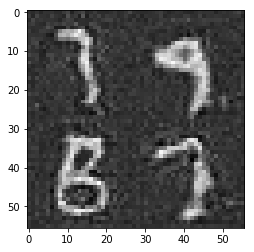

Epoch 1/2... Discriminator Loss: 0.6402... Generator Loss: 1.5401
Epoch 1/2... Discriminator Loss: 0.4988... Generator Loss: 2.1600
Tensor("generator_65/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_65/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_65/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_65/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_66/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_66/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_66/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_66/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


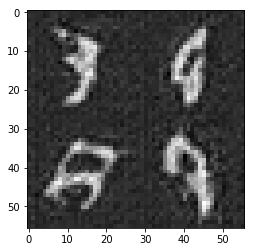

Epoch 1/2... Discriminator Loss: 0.4184... Generator Loss: 3.2396
Epoch 1/2... Discriminator Loss: 0.6787... Generator Loss: 1.4936
Tensor("generator_67/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_67/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_67/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_67/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_68/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_68/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_68/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_68/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


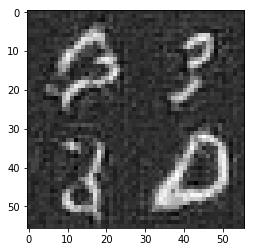

Epoch 1/2... Discriminator Loss: 0.4565... Generator Loss: 2.3678
Epoch 1/2... Discriminator Loss: 0.9172... Generator Loss: 3.2090
Tensor("generator_69/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_69/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_69/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_69/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_70/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_70/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_70/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_70/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


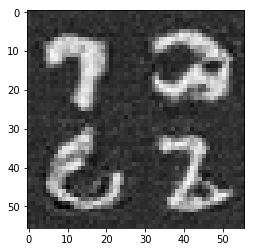

Epoch 1/2... Discriminator Loss: 0.3857... Generator Loss: 4.0390
Epoch 1/2... Discriminator Loss: 0.7309... Generator Loss: 1.3752
Tensor("generator_71/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_71/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_71/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_71/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_72/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_72/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_72/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_72/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


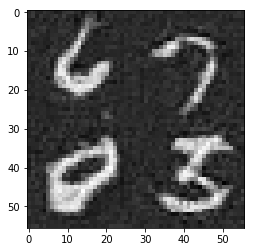

Epoch 1/2... Discriminator Loss: 1.0831... Generator Loss: 0.9387
Epoch 1/2... Discriminator Loss: 0.5378... Generator Loss: 2.9238
Tensor("generator_73/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_73/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_73/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_73/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_74/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_74/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_74/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_74/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


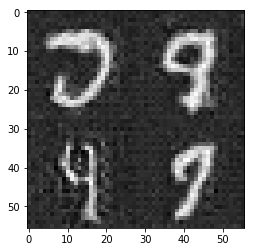

Epoch 1/2... Discriminator Loss: 0.4791... Generator Loss: 2.5974
Epoch 2/2... Discriminator Loss: 0.5201... Generator Loss: 2.0508
Tensor("generator_75/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_75/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_75/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_75/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_76/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_76/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_76/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_76/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


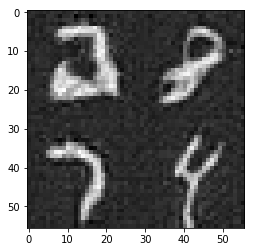

Epoch 2/2... Discriminator Loss: 0.4736... Generator Loss: 2.1615
Epoch 2/2... Discriminator Loss: 0.5971... Generator Loss: 1.7918
Tensor("generator_77/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_77/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_77/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_77/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_78/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_78/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_78/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_78/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


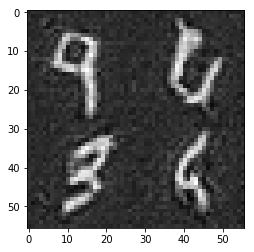

Epoch 2/2... Discriminator Loss: 0.8596... Generator Loss: 1.1604
Epoch 2/2... Discriminator Loss: 0.6410... Generator Loss: 1.7097
Tensor("generator_79/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_79/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_79/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_79/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_80/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_80/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_80/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_80/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


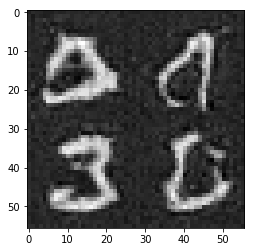

Epoch 2/2... Discriminator Loss: 1.2338... Generator Loss: 0.5878
Epoch 2/2... Discriminator Loss: 0.4499... Generator Loss: 2.4156
Tensor("generator_81/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_81/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_81/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_81/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_82/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_82/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_82/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_82/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


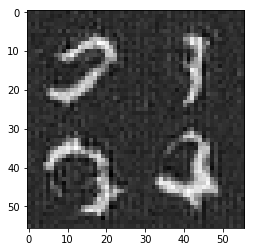

Epoch 2/2... Discriminator Loss: 0.6614... Generator Loss: 1.4564
Epoch 2/2... Discriminator Loss: 0.5008... Generator Loss: 2.3601
Tensor("generator_83/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_83/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_83/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_83/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_84/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_84/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_84/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_84/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


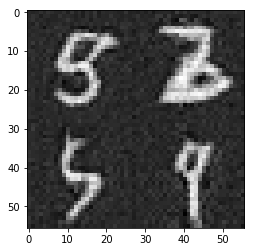

Epoch 2/2... Discriminator Loss: 1.0483... Generator Loss: 2.9077
Epoch 2/2... Discriminator Loss: 1.1052... Generator Loss: 0.8554
Tensor("generator_85/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_85/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_85/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_85/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_86/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_86/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_86/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_86/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


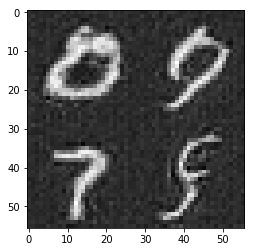

Epoch 2/2... Discriminator Loss: 0.5187... Generator Loss: 2.0286
Epoch 2/2... Discriminator Loss: 0.5681... Generator Loss: 1.8712
Tensor("generator_87/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_87/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_87/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_87/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_88/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_88/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_88/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_88/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


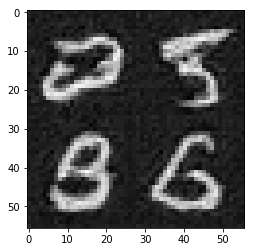

Epoch 2/2... Discriminator Loss: 0.5310... Generator Loss: 1.8895
Epoch 2/2... Discriminator Loss: 0.3675... Generator Loss: 3.6462
Tensor("generator_89/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_89/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_89/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_89/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_90/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_90/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_90/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_90/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


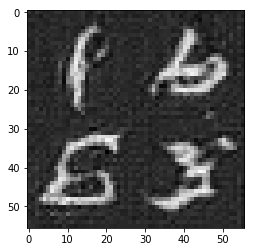

Epoch 2/2... Discriminator Loss: 0.3881... Generator Loss: 3.4336
Epoch 2/2... Discriminator Loss: 0.4317... Generator Loss: 2.7930
Tensor("generator_91/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_91/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_91/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_91/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_92/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_92/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_92/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_92/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


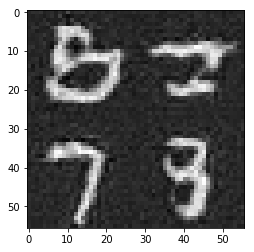

Epoch 2/2... Discriminator Loss: 0.4990... Generator Loss: 2.2611
Epoch 2/2... Discriminator Loss: 0.9024... Generator Loss: 0.8983
Tensor("generator_93/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_93/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_93/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_93/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_94/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_94/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_94/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_94/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


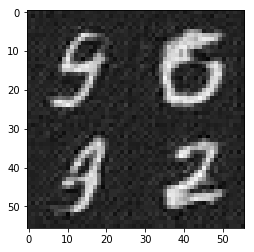

Epoch 2/2... Discriminator Loss: 0.3995... Generator Loss: 2.8519
Epoch 2/2... Discriminator Loss: 0.4108... Generator Loss: 3.0545
Tensor("generator_95/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_95/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_95/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_95/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_96/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_96/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_96/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_96/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


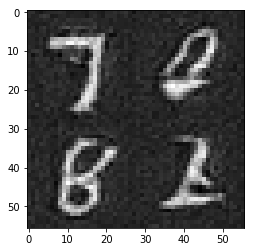

Epoch 2/2... Discriminator Loss: 0.3402... Generator Loss: 5.0666
Epoch 2/2... Discriminator Loss: 0.6118... Generator Loss: 3.1479
Tensor("generator_97/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_97/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_97/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_97/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_98/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_98/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_98/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_98/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


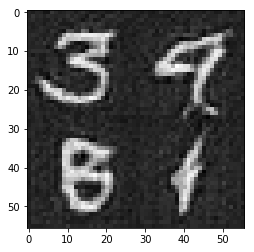

Epoch 2/2... Discriminator Loss: 0.5787... Generator Loss: 1.6455
Epoch 2/2... Discriminator Loss: 0.5818... Generator Loss: 1.8112
Tensor("generator_99/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_99/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_99/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_99/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_100/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_100/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_100/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_100/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


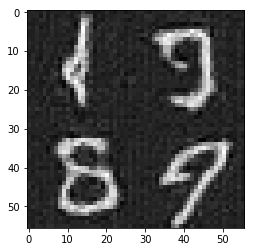

Epoch 2/2... Discriminator Loss: 0.8237... Generator Loss: 1.4100
Epoch 2/2... Discriminator Loss: 0.5167... Generator Loss: 2.3516
Tensor("generator_101/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_101/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_101/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_101/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_102/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_102/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_102/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_102/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


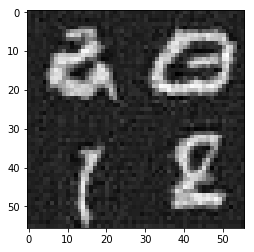

Epoch 2/2... Discriminator Loss: 0.5223... Generator Loss: 2.5072
Epoch 2/2... Discriminator Loss: 0.5280... Generator Loss: 1.9606
Tensor("generator_103/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_103/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_103/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_103/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_104/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_104/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_104/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_104/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


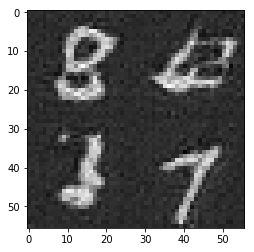

Epoch 2/2... Discriminator Loss: 1.9408... Generator Loss: 4.1291
Epoch 2/2... Discriminator Loss: 0.5322... Generator Loss: 2.0951
Tensor("generator_105/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_105/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_105/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_105/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_106/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_106/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_106/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_106/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


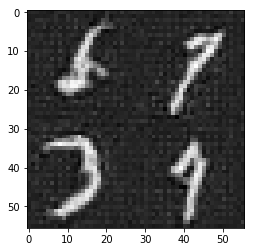

Epoch 2/2... Discriminator Loss: 0.5811... Generator Loss: 1.7150
Epoch 2/2... Discriminator Loss: 0.4216... Generator Loss: 2.6938
Tensor("generator_107/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_107/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_107/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_107/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_108/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_108/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_108/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_108/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


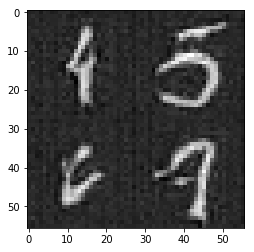

Epoch 2/2... Discriminator Loss: 0.5092... Generator Loss: 2.0137
Epoch 2/2... Discriminator Loss: 0.4404... Generator Loss: 2.9009
Tensor("generator_109/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_109/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_109/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_109/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_110/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_110/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_110/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_110/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


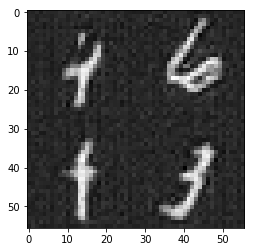

Epoch 2/2... Discriminator Loss: 0.7325... Generator Loss: 1.2612
Epoch 2/2... Discriminator Loss: 0.4302... Generator Loss: 2.8159
Tensor("generator_111/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_111/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_111/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_111/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_112/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_112/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_112/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_112/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


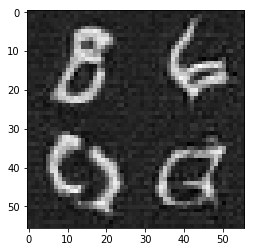

Epoch 2/2... Discriminator Loss: 0.3622... Generator Loss: 3.7309
Epoch 2/2... Discriminator Loss: 0.5812... Generator Loss: 2.0373
Tensor("generator_113/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_113/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_113/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_113/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_114/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_114/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_114/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_114/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


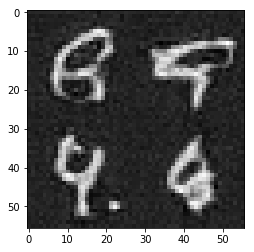

Epoch 2/2... Discriminator Loss: 0.7131... Generator Loss: 1.5044
Epoch 2/2... Discriminator Loss: 0.6712... Generator Loss: 1.4645
Tensor("generator_115/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_115/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_115/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_115/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_116/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_116/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_116/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_116/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


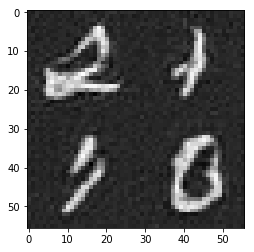

Epoch 2/2... Discriminator Loss: 0.4533... Generator Loss: 2.3002
Epoch 2/2... Discriminator Loss: 0.4802... Generator Loss: 2.1793
Tensor("generator_117/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_117/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_117/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_117/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_118/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_118/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_118/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_118/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


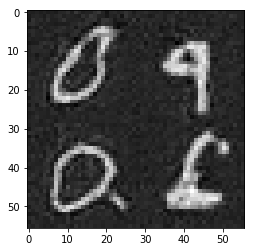

Epoch 2/2... Discriminator Loss: 0.4075... Generator Loss: 3.5638
Epoch 2/2... Discriminator Loss: 0.7608... Generator Loss: 1.2976
Tensor("generator_119/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_119/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_119/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_119/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_120/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_120/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_120/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_120/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


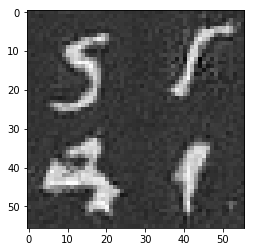

Epoch 2/2... Discriminator Loss: 0.7171... Generator Loss: 1.4187
Epoch 2/2... Discriminator Loss: 0.5192... Generator Loss: 1.9789
Tensor("generator_121/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_121/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_121/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_121/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_122/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_122/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_122/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_122/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


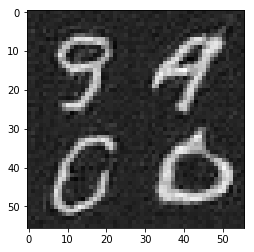

Epoch 2/2... Discriminator Loss: 0.7633... Generator Loss: 2.5128
Epoch 2/2... Discriminator Loss: 0.8432... Generator Loss: 2.9760
Tensor("generator_123/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_123/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_123/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_123/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_124/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_124/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_124/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_124/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


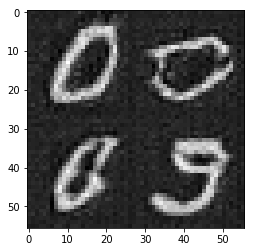

Epoch 2/2... Discriminator Loss: 0.5601... Generator Loss: 1.7446
Epoch 2/2... Discriminator Loss: 0.6317... Generator Loss: 1.5907
Tensor("generator_125/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_125/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_125/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_125/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_126/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_126/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_126/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_126/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


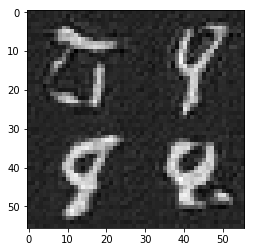

Epoch 2/2... Discriminator Loss: 0.5428... Generator Loss: 2.2648
Epoch 2/2... Discriminator Loss: 0.5361... Generator Loss: 1.9251
Tensor("generator_127/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_127/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_127/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_127/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_128/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_128/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_128/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_128/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


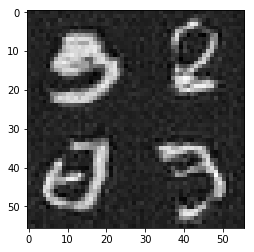

Epoch 2/2... Discriminator Loss: 0.8338... Generator Loss: 1.0623
Epoch 2/2... Discriminator Loss: 0.5858... Generator Loss: 1.6390
Tensor("generator_129/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_129/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_129/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_129/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_130/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_130/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_130/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_130/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


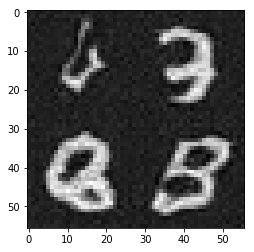

Epoch 2/2... Discriminator Loss: 0.4166... Generator Loss: 3.2267
Epoch 2/2... Discriminator Loss: 0.4013... Generator Loss: 3.0326
Tensor("generator_131/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_131/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_131/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_131/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_132/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_132/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_132/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_132/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


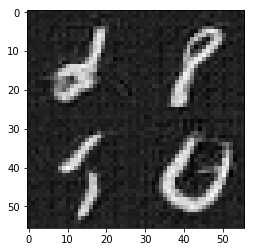

Epoch 2/2... Discriminator Loss: 0.4302... Generator Loss: 2.5238
Epoch 2/2... Discriminator Loss: 0.5383... Generator Loss: 1.9100
Tensor("generator_133/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_133/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_133/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_133/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_134/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_134/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_134/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_134/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


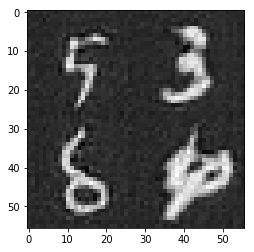

Epoch 2/2... Discriminator Loss: 0.6266... Generator Loss: 2.3592
Epoch 2/2... Discriminator Loss: 0.5495... Generator Loss: 1.9503
Tensor("generator_135/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_135/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_135/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_135/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_136/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_136/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_136/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_136/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


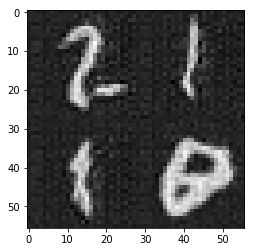

Epoch 2/2... Discriminator Loss: 0.5724... Generator Loss: 1.8735
Epoch 2/2... Discriminator Loss: 0.5066... Generator Loss: 2.0603
Tensor("generator_137/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_137/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_137/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_137/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_138/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_138/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_138/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_138/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


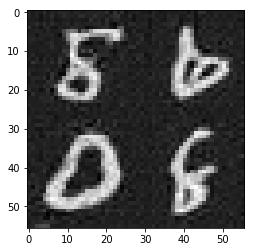

Epoch 2/2... Discriminator Loss: 0.4616... Generator Loss: 2.3018
Epoch 2/2... Discriminator Loss: 0.5341... Generator Loss: 1.8608
Tensor("generator_139/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_139/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_139/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_139/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_140/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_140/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_140/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_140/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


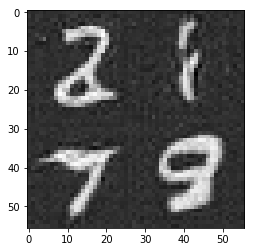

Epoch 2/2... Discriminator Loss: 0.7570... Generator Loss: 1.4382
Epoch 2/2... Discriminator Loss: 0.5253... Generator Loss: 2.2163
Tensor("generator_141/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_141/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_141/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_141/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_142/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_142/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_142/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_142/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


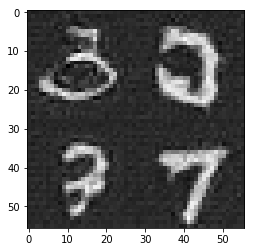

Epoch 2/2... Discriminator Loss: 0.6577... Generator Loss: 1.4310
Epoch 2/2... Discriminator Loss: 0.5783... Generator Loss: 1.7706
Tensor("generator_143/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_143/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_143/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_143/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_144/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_144/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_144/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_144/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


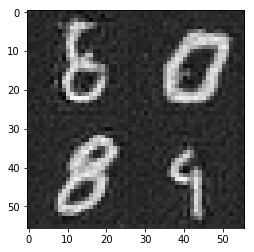

Epoch 2/2... Discriminator Loss: 0.5494... Generator Loss: 1.8159
Epoch 2/2... Discriminator Loss: 0.4516... Generator Loss: 2.4754
Tensor("generator_145/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_145/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_145/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_145/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_146/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_146/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_146/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_146/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


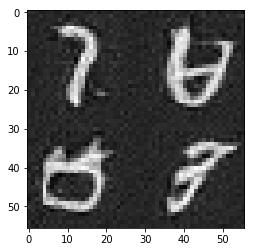

Epoch 2/2... Discriminator Loss: 0.5136... Generator Loss: 2.0944
Epoch 2/2... Discriminator Loss: 0.4238... Generator Loss: 2.6606
Tensor("generator_147/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_147/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_147/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_147/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_148/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_148/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_148/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_148/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


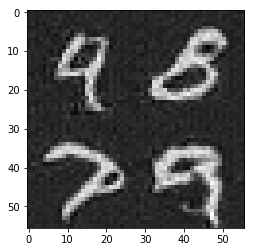

Epoch 2/2... Discriminator Loss: 0.9878... Generator Loss: 0.8557
Epoch 2/2... Discriminator Loss: 0.4727... Generator Loss: 2.3282
Tensor("generator_149/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_149/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_149/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_149/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("generator_150/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_150/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_150/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_150/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


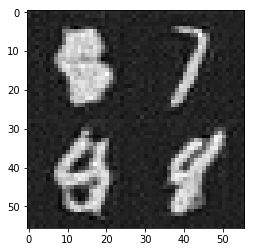

In [14]:
batch_size = 16  #Try reducing batch_size to (~16 to 32)
z_dim = 100
learning_rate = 0.0005  #DCGAN with this architectural structure remains stable with lr between 0.0001 and 0.0008
beta1 = 0.5  #The beta1 is too high. Values like 0.3 to 0.5 have shown to get best results.


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Tensor("generator/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Epoch 1/1... Discriminator Loss: 2.5810... Generator Loss: 0.1562
Epoch 1/1... Discriminator Loss: 0.8485... Generator Loss: 4.1541
Tensor("generator_1/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_1/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_1/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_1/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_2/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_2/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_2/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_2/conv2d_transpose_3/BiasAdd:0", shape=(?, 

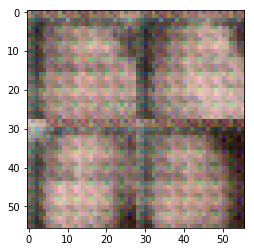

Epoch 1/1... Discriminator Loss: 1.9449... Generator Loss: 0.3195
Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 0.8427
Tensor("generator_3/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_3/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_3/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_3/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_4/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_4/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_4/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_4/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


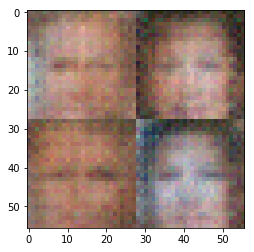

Epoch 1/1... Discriminator Loss: 1.8255... Generator Loss: 0.2982
Epoch 1/1... Discriminator Loss: 0.8210... Generator Loss: 1.3616
Tensor("generator_5/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_5/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_5/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_5/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_6/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_6/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_6/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_6/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


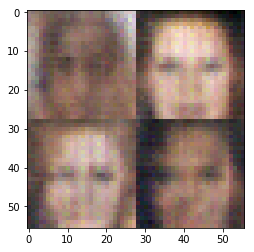

Epoch 1/1... Discriminator Loss: 1.7993... Generator Loss: 0.3590
Epoch 1/1... Discriminator Loss: 0.5474... Generator Loss: 1.9443
Tensor("generator_7/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_7/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_7/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_7/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_8/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_8/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_8/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_8/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


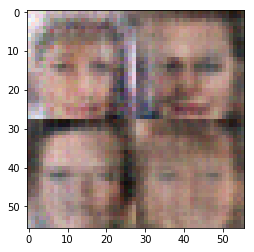

Epoch 1/1... Discriminator Loss: 0.3985... Generator Loss: 4.0781
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 7.6636
Tensor("generator_9/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_9/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_9/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_9/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_10/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_10/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_10/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_10/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


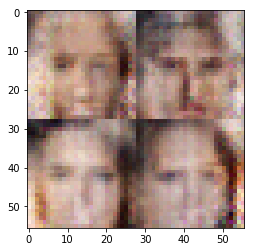

Epoch 1/1... Discriminator Loss: 0.5082... Generator Loss: 2.5054
Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 3.4556
Tensor("generator_11/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_11/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_11/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_11/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_12/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_12/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_12/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_12/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


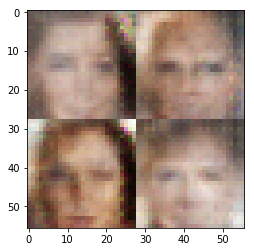

Epoch 1/1... Discriminator Loss: 0.4175... Generator Loss: 4.7357
Epoch 1/1... Discriminator Loss: 0.8411... Generator Loss: 1.5651
Tensor("generator_13/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_13/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_13/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_13/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_14/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_14/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_14/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_14/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


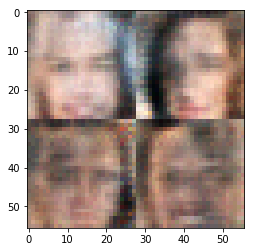

Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 0.4014... Generator Loss: 2.8814
Tensor("generator_15/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_15/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_15/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_15/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_16/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_16/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_16/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_16/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


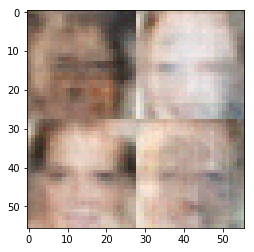

Epoch 1/1... Discriminator Loss: 0.3471... Generator Loss: 5.6436
Epoch 1/1... Discriminator Loss: 0.6552... Generator Loss: 1.5839
Tensor("generator_17/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_17/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_17/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_17/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_18/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_18/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_18/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_18/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


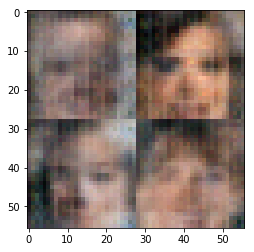

Epoch 1/1... Discriminator Loss: 0.3775... Generator Loss: 5.6968
Epoch 1/1... Discriminator Loss: 0.3745... Generator Loss: 4.3571
Tensor("generator_19/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_19/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_19/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_19/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_20/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_20/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_20/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_20/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


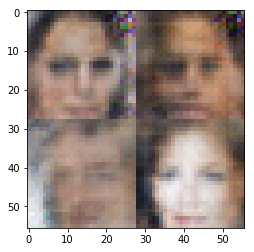

Epoch 1/1... Discriminator Loss: 0.4191... Generator Loss: 2.6268
Epoch 1/1... Discriminator Loss: 0.4761... Generator Loss: 2.1207
Tensor("generator_21/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_21/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_21/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_21/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_22/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_22/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_22/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_22/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


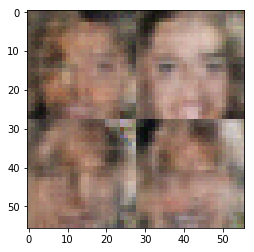

Epoch 1/1... Discriminator Loss: 0.3705... Generator Loss: 4.2327
Epoch 1/1... Discriminator Loss: 0.3387... Generator Loss: 6.5933
Tensor("generator_23/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_23/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_23/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_23/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_24/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_24/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_24/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_24/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


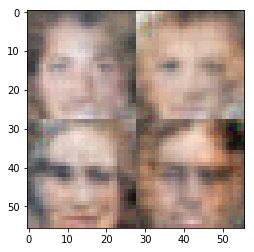

Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 0.3668... Generator Loss: 4.7065
Tensor("generator_25/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_25/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_25/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_25/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_26/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_26/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_26/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_26/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


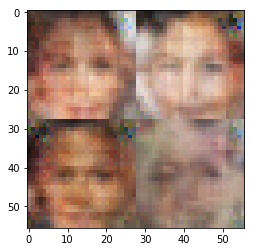

Epoch 1/1... Discriminator Loss: 0.6133... Generator Loss: 1.6408
Epoch 1/1... Discriminator Loss: 0.4413... Generator Loss: 2.7551
Tensor("generator_27/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_27/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_27/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_27/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_28/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_28/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_28/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_28/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


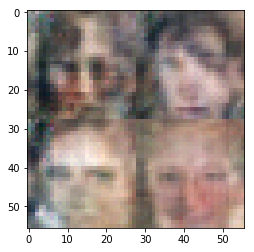

Epoch 1/1... Discriminator Loss: 0.3612... Generator Loss: 7.8645
Epoch 1/1... Discriminator Loss: 0.3450... Generator Loss: 6.1596
Tensor("generator_29/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_29/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_29/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_29/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_30/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_30/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_30/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_30/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


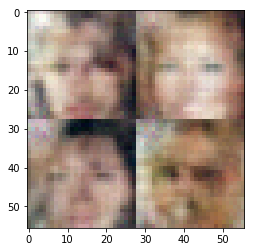

Epoch 1/1... Discriminator Loss: 0.4479... Generator Loss: 2.8133
Epoch 1/1... Discriminator Loss: 0.4287... Generator Loss: 2.8890
Tensor("generator_31/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_31/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_31/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_31/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_32/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_32/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_32/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_32/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


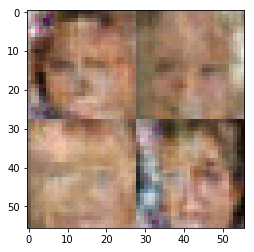

Epoch 1/1... Discriminator Loss: 0.8319... Generator Loss: 1.1354
Epoch 1/1... Discriminator Loss: 0.7966... Generator Loss: 1.2416
Tensor("generator_33/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_33/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_33/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_33/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_34/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_34/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_34/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_34/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


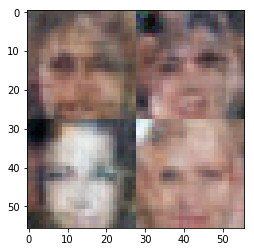

Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 3.0510
Tensor("generator_35/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_35/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_35/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_35/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_36/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_36/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_36/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_36/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


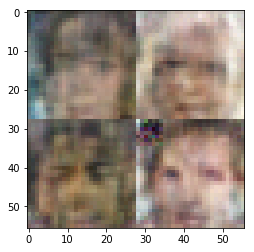

Epoch 1/1... Discriminator Loss: 0.4282... Generator Loss: 3.0860
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.6443
Tensor("generator_37/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_37/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_37/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_37/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_38/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_38/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_38/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_38/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


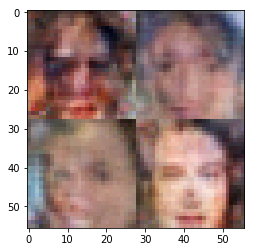

Epoch 1/1... Discriminator Loss: 0.4861... Generator Loss: 2.5347
Epoch 1/1... Discriminator Loss: 0.7616... Generator Loss: 1.4046
Tensor("generator_39/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_39/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_39/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_39/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_40/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_40/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_40/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_40/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


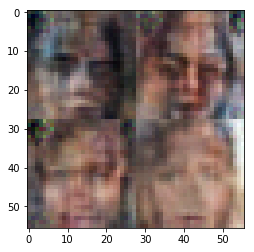

Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 1.8623
Epoch 1/1... Discriminator Loss: 0.3537... Generator Loss: 4.4980
Tensor("generator_41/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_41/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_41/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_41/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_42/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_42/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_42/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_42/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


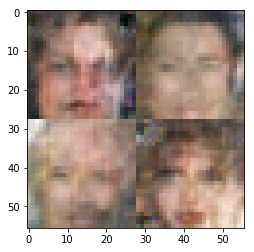

Epoch 1/1... Discriminator Loss: 1.6747... Generator Loss: 0.4201
Epoch 1/1... Discriminator Loss: 0.5054... Generator Loss: 3.8115
Tensor("generator_43/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_43/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_43/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_43/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_44/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_44/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_44/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_44/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


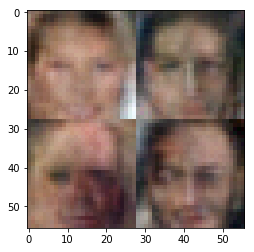

Epoch 1/1... Discriminator Loss: 0.8705... Generator Loss: 1.2320
Epoch 1/1... Discriminator Loss: 1.8033... Generator Loss: 0.4480
Tensor("generator_45/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_45/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_45/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_45/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_46/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_46/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_46/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_46/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


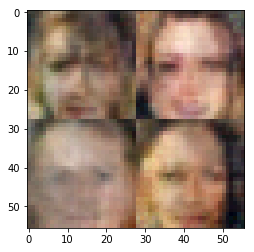

Epoch 1/1... Discriminator Loss: 0.3488... Generator Loss: 5.3472
Epoch 1/1... Discriminator Loss: 0.3525... Generator Loss: 5.1752
Tensor("generator_47/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_47/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_47/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_47/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_48/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_48/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_48/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_48/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


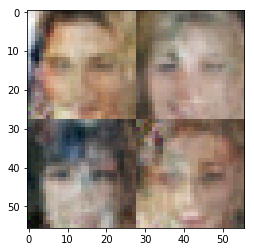

Epoch 1/1... Discriminator Loss: 0.5916... Generator Loss: 2.1165
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.6413
Tensor("generator_49/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_49/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_49/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_49/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_50/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_50/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_50/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_50/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


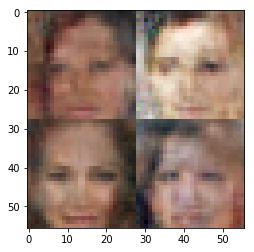

Epoch 1/1... Discriminator Loss: 0.5285... Generator Loss: 6.6636
Epoch 1/1... Discriminator Loss: 0.3707... Generator Loss: 4.8745
Tensor("generator_51/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_51/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_51/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_51/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_52/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_52/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_52/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_52/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


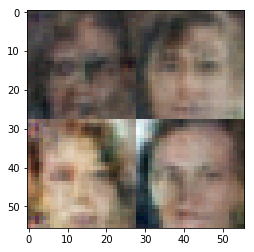

Epoch 1/1... Discriminator Loss: 0.3811... Generator Loss: 4.0528
Epoch 1/1... Discriminator Loss: 0.4281... Generator Loss: 3.0272
Tensor("generator_53/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_53/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_53/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_53/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_54/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_54/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_54/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_54/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


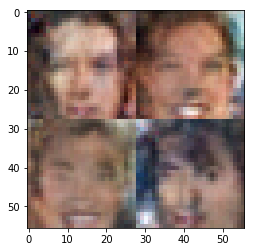

Epoch 1/1... Discriminator Loss: 0.3894... Generator Loss: 3.5305
Epoch 1/1... Discriminator Loss: 0.4672... Generator Loss: 5.4502
Tensor("generator_55/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_55/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_55/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_55/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_56/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_56/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_56/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_56/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


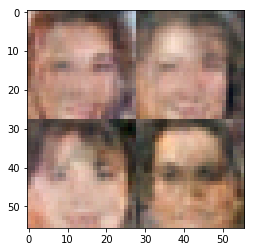

Epoch 1/1... Discriminator Loss: 0.6002... Generator Loss: 2.7221
Epoch 1/1... Discriminator Loss: 2.6362... Generator Loss: 0.1502
Tensor("generator_57/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_57/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_57/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_57/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_58/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_58/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_58/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_58/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


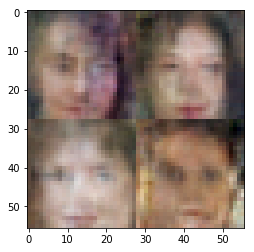

Epoch 1/1... Discriminator Loss: 0.4602... Generator Loss: 2.6572
Epoch 1/1... Discriminator Loss: 0.4264... Generator Loss: 2.7150
Tensor("generator_59/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_59/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_59/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_59/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_60/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_60/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_60/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_60/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


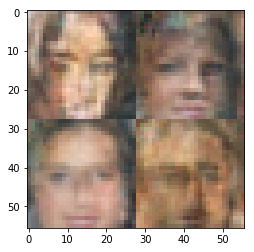

Epoch 1/1... Discriminator Loss: 0.3856... Generator Loss: 3.8311
Epoch 1/1... Discriminator Loss: 0.5612... Generator Loss: 5.9276
Tensor("generator_61/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_61/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_61/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_61/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_62/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_62/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_62/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_62/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


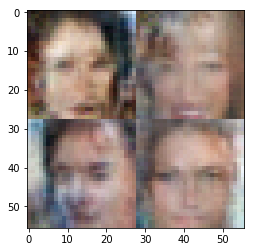

Epoch 1/1... Discriminator Loss: 1.9205... Generator Loss: 2.9220
Epoch 1/1... Discriminator Loss: 0.3559... Generator Loss: 5.4874
Tensor("generator_63/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_63/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_63/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_63/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_64/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_64/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_64/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_64/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


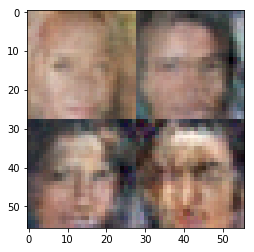

Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 0.3919... Generator Loss: 3.3413
Tensor("generator_65/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_65/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_65/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_65/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_66/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_66/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_66/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_66/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


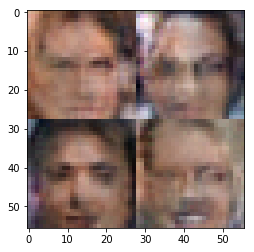

Epoch 1/1... Discriminator Loss: 1.7850... Generator Loss: 0.3895
Epoch 1/1... Discriminator Loss: 0.7623... Generator Loss: 1.4580
Tensor("generator_67/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_67/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_67/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_67/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_68/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_68/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_68/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_68/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


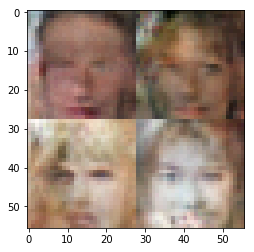

Epoch 1/1... Discriminator Loss: 0.3828... Generator Loss: 4.8170
Epoch 1/1... Discriminator Loss: 0.3735... Generator Loss: 4.5384
Tensor("generator_69/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_69/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_69/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_69/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_70/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_70/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_70/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_70/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


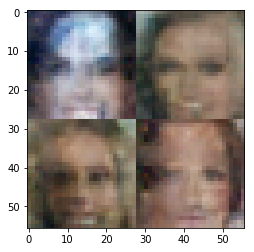

Epoch 1/1... Discriminator Loss: 0.3745... Generator Loss: 3.6503
Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 2.7985
Tensor("generator_71/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_71/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_71/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_71/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_72/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_72/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_72/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_72/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


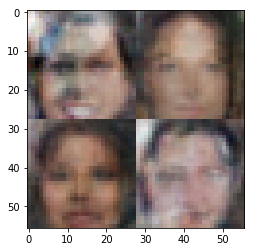

Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 6.2048
Epoch 1/1... Discriminator Loss: 0.3433... Generator Loss: 5.4324
Tensor("generator_73/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_73/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_73/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_73/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_74/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_74/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_74/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_74/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


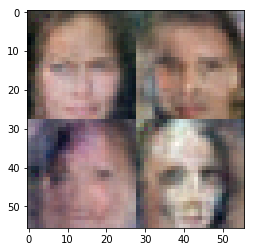

Epoch 1/1... Discriminator Loss: 0.7868... Generator Loss: 4.3215
Epoch 1/1... Discriminator Loss: 0.3505... Generator Loss: 4.9776
Tensor("generator_75/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_75/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_75/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_75/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_76/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_76/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_76/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_76/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


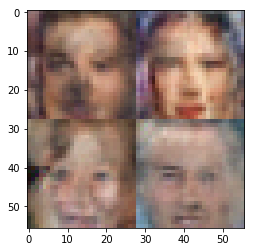

Epoch 1/1... Discriminator Loss: 0.4155... Generator Loss: 4.0299
Epoch 1/1... Discriminator Loss: 0.4599... Generator Loss: 2.4485
Tensor("generator_77/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_77/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_77/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_77/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_78/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_78/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_78/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_78/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


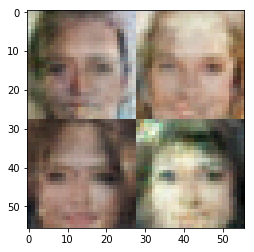

Epoch 1/1... Discriminator Loss: 0.7691... Generator Loss: 1.1842
Epoch 1/1... Discriminator Loss: 0.8044... Generator Loss: 1.4148
Tensor("generator_79/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_79/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_79/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_79/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_80/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_80/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_80/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_80/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


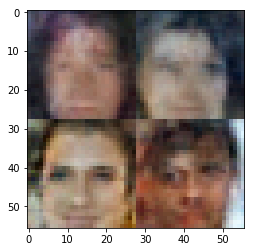

Epoch 1/1... Discriminator Loss: 2.3596... Generator Loss: 0.1985
Epoch 1/1... Discriminator Loss: 0.4575... Generator Loss: 4.1318
Tensor("generator_81/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_81/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_81/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_81/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_82/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_82/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_82/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_82/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


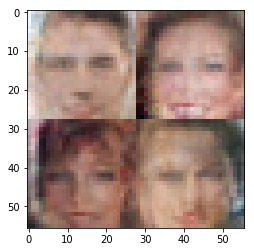

Epoch 1/1... Discriminator Loss: 0.5239... Generator Loss: 1.9543
Epoch 1/1... Discriminator Loss: 0.4049... Generator Loss: 3.0589
Tensor("generator_83/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_83/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_83/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_83/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_84/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_84/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_84/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_84/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


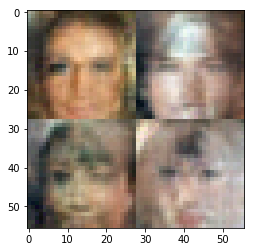

Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 1.2383
Epoch 1/1... Discriminator Loss: 0.3882... Generator Loss: 3.2315
Tensor("generator_85/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_85/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_85/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_85/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_86/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_86/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_86/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_86/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


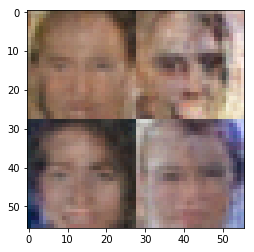

Epoch 1/1... Discriminator Loss: 0.4026... Generator Loss: 3.5421
Epoch 1/1... Discriminator Loss: 0.8337... Generator Loss: 8.6736
Tensor("generator_87/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_87/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_87/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_87/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_88/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_88/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_88/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_88/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


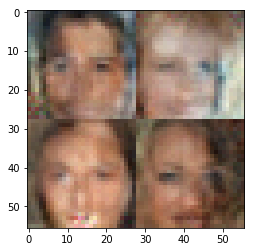

Epoch 1/1... Discriminator Loss: 0.6770... Generator Loss: 1.4965
Epoch 1/1... Discriminator Loss: 0.3563... Generator Loss: 5.3746
Tensor("generator_89/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_89/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_89/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_89/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_90/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_90/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_90/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_90/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


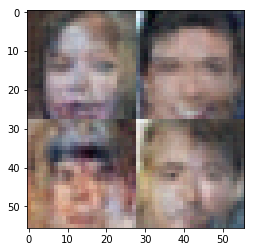

Epoch 1/1... Discriminator Loss: 0.5161... Generator Loss: 2.4177
Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 1.0173
Tensor("generator_91/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_91/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_91/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_91/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_92/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_92/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_92/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_92/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


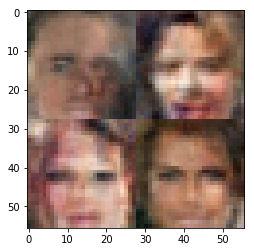

Epoch 1/1... Discriminator Loss: 0.7727... Generator Loss: 1.2143
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 1.6276
Tensor("generator_93/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_93/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_93/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_93/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_94/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_94/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_94/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_94/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


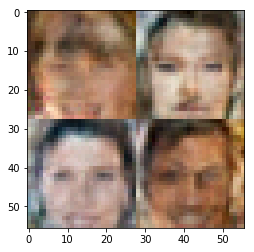

Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 1.7962
Epoch 1/1... Discriminator Loss: 0.9623... Generator Loss: 1.2837
Tensor("generator_95/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_95/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_95/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_95/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_96/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_96/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_96/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_96/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


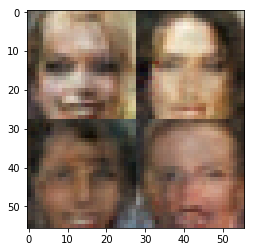

Epoch 1/1... Discriminator Loss: 0.6234... Generator Loss: 1.6377
Epoch 1/1... Discriminator Loss: 0.5558... Generator Loss: 1.9541
Tensor("generator_97/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_97/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_97/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_97/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_98/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_98/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_98/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_98/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


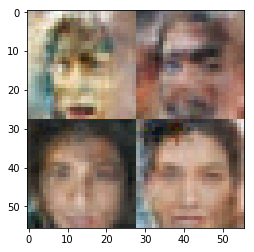

Epoch 1/1... Discriminator Loss: 0.4341... Generator Loss: 4.3476
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.5802
Tensor("generator_99/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_99/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_99/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_99/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_100/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_100/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_100/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_100/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


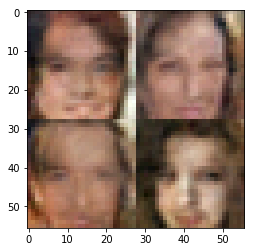

Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 2.4565
Epoch 1/1... Discriminator Loss: 0.5559... Generator Loss: 1.8118
Tensor("generator_101/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_101/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_101/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_101/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_102/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_102/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_102/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_102/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


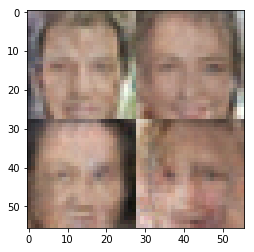

Epoch 1/1... Discriminator Loss: 0.4687... Generator Loss: 2.4420
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.7077
Tensor("generator_103/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_103/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_103/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_103/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_104/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_104/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_104/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_104/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


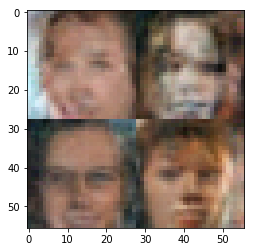

Epoch 1/1... Discriminator Loss: 0.5880... Generator Loss: 2.1118
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 0.7944
Tensor("generator_105/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_105/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_105/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_105/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_106/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_106/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_106/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_106/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


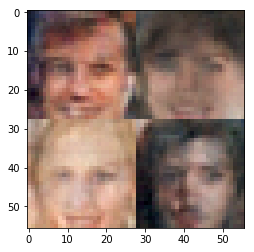

Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.0865
Epoch 1/1... Discriminator Loss: 0.8702... Generator Loss: 2.2187
Tensor("generator_107/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_107/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_107/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_107/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_108/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_108/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_108/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_108/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


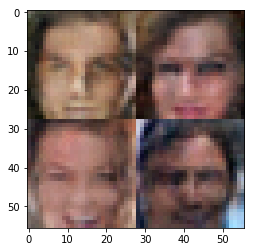

Epoch 1/1... Discriminator Loss: 0.4431... Generator Loss: 2.6256
Epoch 1/1... Discriminator Loss: 0.8773... Generator Loss: 2.9199
Tensor("generator_109/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_109/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_109/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_109/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_110/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_110/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_110/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_110/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


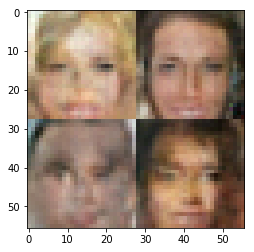

Epoch 1/1... Discriminator Loss: 0.5543... Generator Loss: 1.7761
Epoch 1/1... Discriminator Loss: 0.4476... Generator Loss: 3.4498
Tensor("generator_111/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_111/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_111/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_111/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_112/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_112/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_112/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_112/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


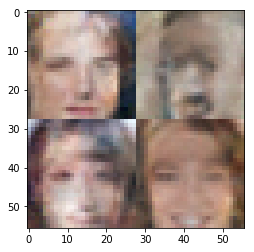

Epoch 1/1... Discriminator Loss: 0.4865... Generator Loss: 2.1122
Epoch 1/1... Discriminator Loss: 0.3540... Generator Loss: 5.0794
Tensor("generator_113/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_113/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_113/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_113/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_114/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_114/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_114/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_114/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


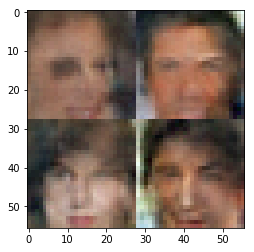

Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.4792
Epoch 1/1... Discriminator Loss: 0.3847... Generator Loss: 3.3003
Tensor("generator_115/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_115/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_115/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_115/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_116/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_116/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_116/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_116/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


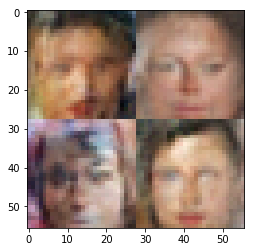

Epoch 1/1... Discriminator Loss: 0.5860... Generator Loss: 4.5326
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.5653
Tensor("generator_117/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_117/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_117/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_117/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_118/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_118/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_118/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_118/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


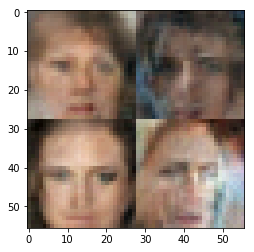

Epoch 1/1... Discriminator Loss: 0.4953... Generator Loss: 2.4306
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 0.7435
Tensor("generator_119/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_119/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_119/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_119/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_120/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_120/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_120/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_120/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


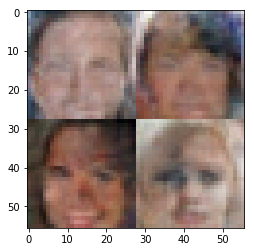

Epoch 1/1... Discriminator Loss: 0.5372... Generator Loss: 3.2608
Epoch 1/1... Discriminator Loss: 2.2344... Generator Loss: 0.2038
Tensor("generator_121/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_121/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_121/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_121/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_122/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_122/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_122/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_122/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


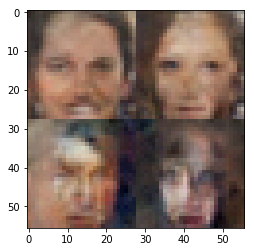

Epoch 1/1... Discriminator Loss: 2.8168... Generator Loss: 0.1103
Epoch 1/1... Discriminator Loss: 0.4096... Generator Loss: 3.3512
Tensor("generator_123/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_123/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_123/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_123/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_124/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_124/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_124/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_124/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


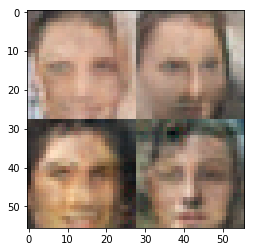

Epoch 1/1... Discriminator Loss: 0.4670... Generator Loss: 4.0687
Epoch 1/1... Discriminator Loss: 0.8696... Generator Loss: 1.1176
Tensor("generator_125/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_125/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_125/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_125/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_126/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_126/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_126/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_126/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


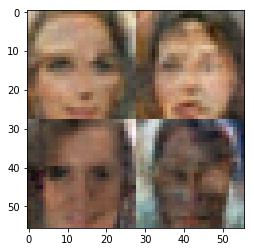

Epoch 1/1... Discriminator Loss: 0.7696... Generator Loss: 1.8180
Epoch 1/1... Discriminator Loss: 0.7128... Generator Loss: 1.8465
Tensor("generator_127/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_127/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_127/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_127/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_128/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_128/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_128/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_128/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


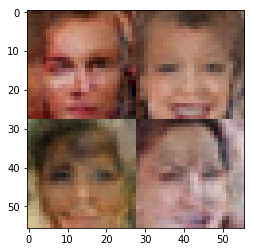

Epoch 1/1... Discriminator Loss: 0.4809... Generator Loss: 2.3708
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 4.1611
Tensor("generator_129/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_129/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_129/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_129/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_130/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_130/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_130/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_130/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


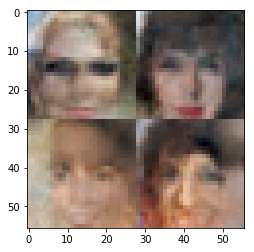

Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 1.3810
Tensor("generator_131/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_131/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_131/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_131/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_132/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_132/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_132/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_132/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


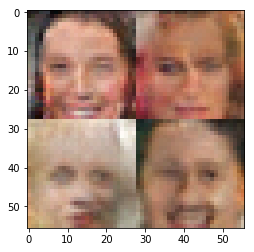

Epoch 1/1... Discriminator Loss: 0.8418... Generator Loss: 1.2466
Epoch 1/1... Discriminator Loss: 0.7672... Generator Loss: 1.1891
Tensor("generator_133/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_133/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_133/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_133/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_134/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_134/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_134/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_134/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


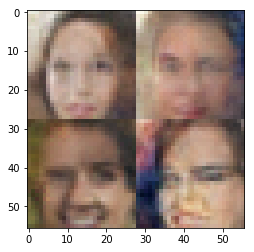

Epoch 1/1... Discriminator Loss: 0.6992... Generator Loss: 2.9387
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 2.6410
Tensor("generator_135/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_135/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_135/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_135/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_136/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_136/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_136/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_136/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


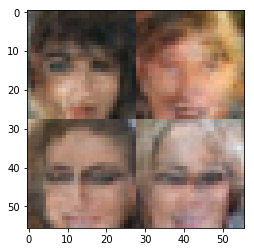

Epoch 1/1... Discriminator Loss: 1.8794... Generator Loss: 0.3049
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.4573
Tensor("generator_137/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_137/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_137/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_137/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_138/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_138/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_138/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_138/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


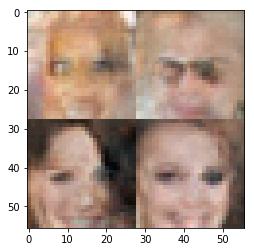

Epoch 1/1... Discriminator Loss: 0.6842... Generator Loss: 1.7956
Epoch 1/1... Discriminator Loss: 1.8293... Generator Loss: 0.3235
Tensor("generator_139/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_139/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_139/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_139/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_140/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_140/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_140/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_140/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


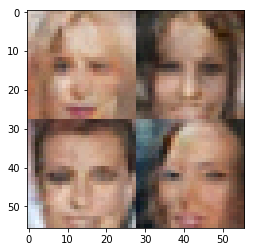

Epoch 1/1... Discriminator Loss: 0.6454... Generator Loss: 2.2622
Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 1.3355
Tensor("generator_141/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_141/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_141/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_141/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_142/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_142/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_142/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_142/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


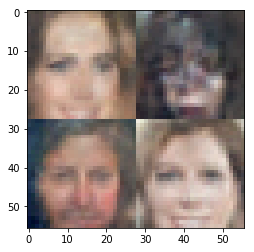

Epoch 1/1... Discriminator Loss: 0.6098... Generator Loss: 2.2045
Epoch 1/1... Discriminator Loss: 1.8917... Generator Loss: 0.2858
Tensor("generator_143/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_143/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_143/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_143/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_144/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_144/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_144/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_144/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


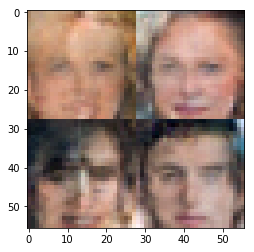

Epoch 1/1... Discriminator Loss: 0.7604... Generator Loss: 1.2540
Epoch 1/1... Discriminator Loss: 0.6519... Generator Loss: 1.5616
Tensor("generator_145/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_145/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_145/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_145/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_146/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_146/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_146/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_146/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


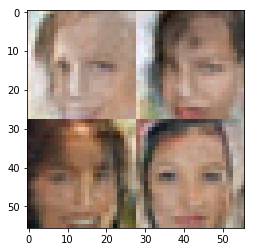

Epoch 1/1... Discriminator Loss: 0.6187... Generator Loss: 1.5809
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 0.6730
Tensor("generator_147/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_147/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_147/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_147/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_148/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_148/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_148/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_148/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


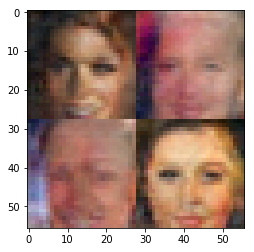

Epoch 1/1... Discriminator Loss: 0.8668... Generator Loss: 1.1060
Epoch 1/1... Discriminator Loss: 1.5479... Generator Loss: 0.3667
Tensor("generator_149/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_149/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_149/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_149/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_150/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_150/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_150/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_150/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


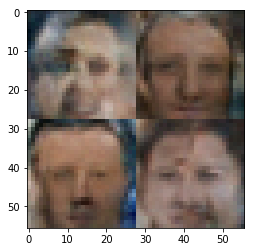

Epoch 1/1... Discriminator Loss: 0.8342... Generator Loss: 1.1529
Epoch 1/1... Discriminator Loss: 0.6335... Generator Loss: 1.6894
Tensor("generator_151/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_151/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_151/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_151/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_152/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_152/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_152/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_152/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


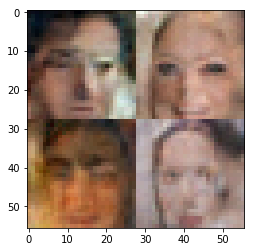

Epoch 1/1... Discriminator Loss: 0.8317... Generator Loss: 1.5963
Epoch 1/1... Discriminator Loss: 0.8270... Generator Loss: 1.1660
Tensor("generator_153/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_153/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_153/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_153/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_154/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_154/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_154/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_154/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


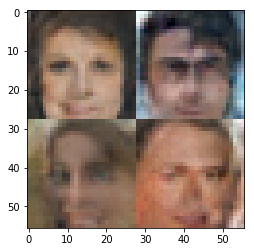

Epoch 1/1... Discriminator Loss: 2.0909... Generator Loss: 0.2009
Epoch 1/1... Discriminator Loss: 0.8428... Generator Loss: 1.0575
Tensor("generator_155/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_155/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_155/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_155/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_156/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_156/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_156/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_156/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


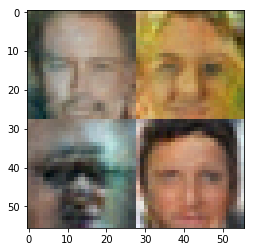

Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.1071
Tensor("generator_157/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_157/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_157/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_157/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_158/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_158/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_158/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_158/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


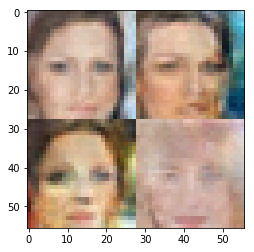

Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.5097
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 0.5809
Tensor("generator_159/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_159/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_159/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_159/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_160/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_160/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_160/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_160/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


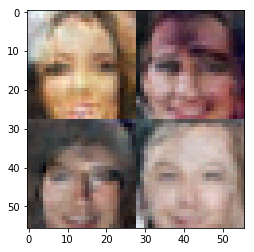

Epoch 1/1... Discriminator Loss: 1.5448... Generator Loss: 0.4154
Epoch 1/1... Discriminator Loss: 1.5610... Generator Loss: 0.4241
Tensor("generator_161/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_161/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_161/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_161/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_162/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_162/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_162/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_162/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


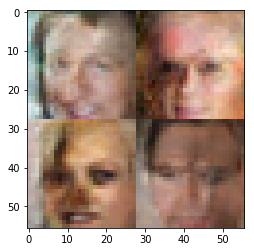

Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 0.8696... Generator Loss: 1.1797
Tensor("generator_163/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_163/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_163/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_163/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_164/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_164/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_164/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_164/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


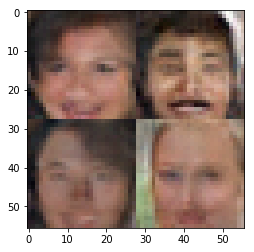

Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 0.8037... Generator Loss: 1.2510
Tensor("generator_165/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_165/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_165/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_165/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_166/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_166/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_166/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_166/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


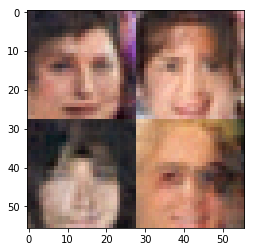

Epoch 1/1... Discriminator Loss: 0.8128... Generator Loss: 1.2635
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.5298
Tensor("generator_167/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_167/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_167/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_167/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_168/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_168/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_168/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_168/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


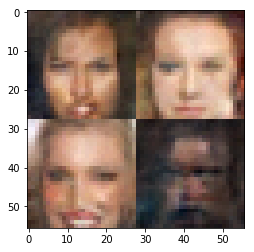

Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 1.1002
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.6183
Tensor("generator_169/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_169/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_169/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_169/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_170/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_170/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_170/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_170/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


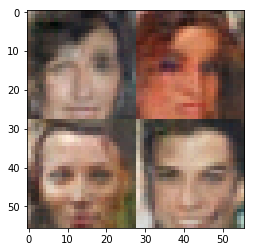

Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.5984
Epoch 1/1... Discriminator Loss: 0.7511... Generator Loss: 1.2708
Tensor("generator_171/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_171/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_171/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_171/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_172/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_172/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_172/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_172/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


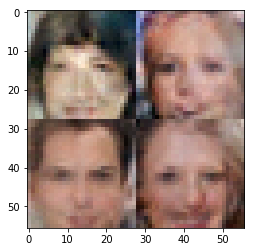

Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.6129
Tensor("generator_173/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_173/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_173/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_173/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_174/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_174/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_174/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_174/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


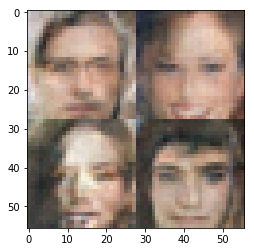

Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.5318
Tensor("generator_175/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_175/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_175/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_175/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_176/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_176/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_176/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_176/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


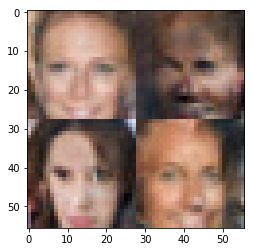

Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.5176
Epoch 1/1... Discriminator Loss: 0.8465... Generator Loss: 1.0252
Tensor("generator_177/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_177/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_177/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_177/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_178/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_178/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_178/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_178/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


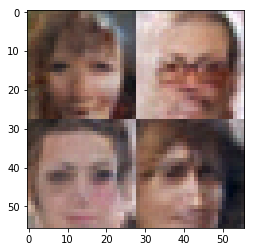

Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 1.2293
Tensor("generator_179/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_179/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_179/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_179/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_180/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_180/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_180/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_180/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


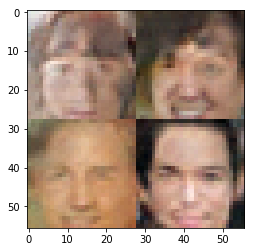

Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.8203
Tensor("generator_181/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_181/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_181/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_181/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_182/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_182/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_182/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_182/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


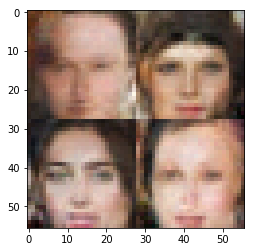

Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.4687
Tensor("generator_183/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_183/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_183/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_183/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_184/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_184/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_184/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_184/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


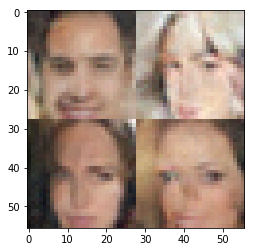

Epoch 1/1... Discriminator Loss: 0.9013... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 1.4903... Generator Loss: 0.4723
Tensor("generator_185/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_185/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_185/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_185/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_186/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_186/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_186/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_186/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


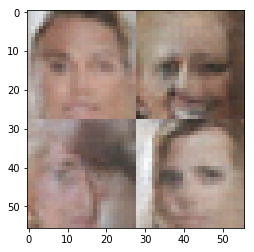

Epoch 1/1... Discriminator Loss: 0.6825... Generator Loss: 1.4439
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 0.7223
Tensor("generator_187/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_187/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_187/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_187/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_188/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_188/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_188/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_188/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


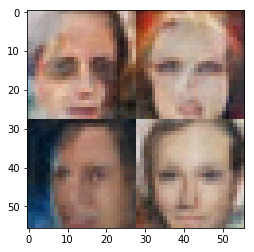

Epoch 1/1... Discriminator Loss: 2.3040... Generator Loss: 0.1997
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.4552
Tensor("generator_189/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_189/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_189/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_189/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_190/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_190/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_190/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_190/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


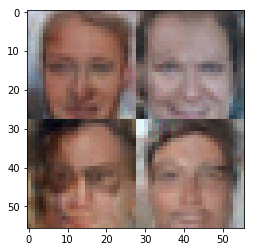

Epoch 1/1... Discriminator Loss: 0.5731... Generator Loss: 3.1536
Epoch 1/1... Discriminator Loss: 0.4817... Generator Loss: 2.8158
Tensor("generator_191/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_191/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_191/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_191/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_192/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_192/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_192/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_192/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


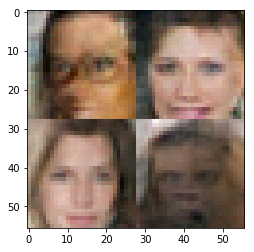

Epoch 1/1... Discriminator Loss: 3.0339... Generator Loss: 0.1058
Epoch 1/1... Discriminator Loss: 2.2239... Generator Loss: 0.2125
Tensor("generator_193/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_193/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_193/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_193/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_194/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_194/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_194/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_194/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


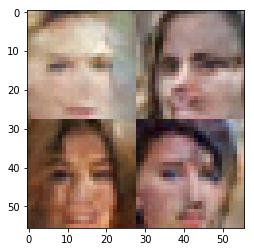

Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 1.3207
Epoch 1/1... Discriminator Loss: 0.6507... Generator Loss: 2.1749
Tensor("generator_195/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_195/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_195/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_195/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_196/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_196/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_196/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_196/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


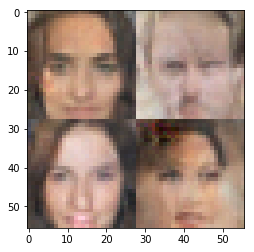

Epoch 1/1... Discriminator Loss: 0.6805... Generator Loss: 2.2755
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 1.5023
Tensor("generator_197/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_197/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_197/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_197/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_198/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_198/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_198/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_198/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


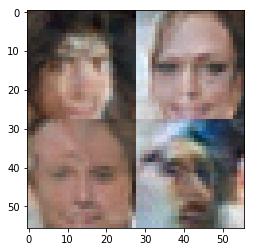

Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.5915... Generator Loss: 0.3750
Tensor("generator_199/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_199/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_199/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_199/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_200/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_200/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_200/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_200/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


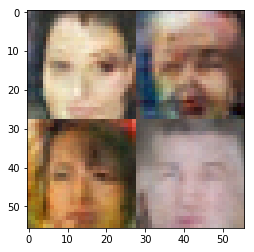

Epoch 1/1... Discriminator Loss: 0.4853... Generator Loss: 2.4322
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.6818
Tensor("generator_201/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_201/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_201/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_201/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_202/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_202/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_202/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_202/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


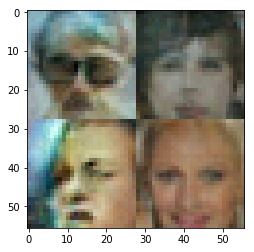

Epoch 1/1... Discriminator Loss: 0.6452... Generator Loss: 2.0376
Epoch 1/1... Discriminator Loss: 0.6420... Generator Loss: 3.4496
Tensor("generator_203/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_203/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_203/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_203/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_204/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_204/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_204/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_204/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


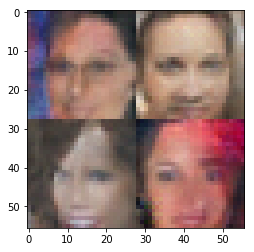

Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 1.8756
Epoch 1/1... Discriminator Loss: 1.5299... Generator Loss: 0.4697
Tensor("generator_205/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_205/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_205/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_205/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_206/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_206/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_206/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_206/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


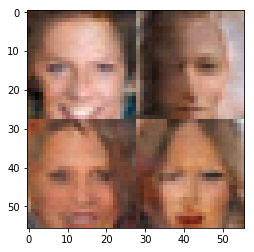

Epoch 1/1... Discriminator Loss: 0.7113... Generator Loss: 1.3316
Epoch 1/1... Discriminator Loss: 0.8422... Generator Loss: 1.0658
Tensor("generator_207/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_207/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_207/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_207/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_208/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_208/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_208/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_208/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


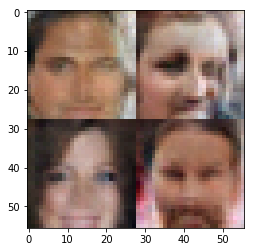

Epoch 1/1... Discriminator Loss: 0.5324... Generator Loss: 2.7469
Epoch 1/1... Discriminator Loss: 1.9297... Generator Loss: 0.2681
Tensor("generator_209/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_209/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_209/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_209/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_210/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_210/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_210/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_210/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


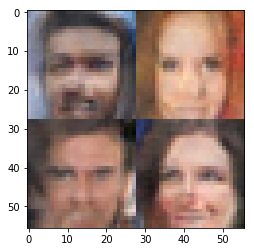

Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 1.0438
Epoch 1/1... Discriminator Loss: 0.8696... Generator Loss: 1.0039
Tensor("generator_211/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_211/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_211/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_211/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_212/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_212/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_212/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_212/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


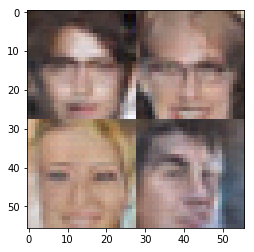

Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 0.9129
Epoch 1/1... Discriminator Loss: 0.7311... Generator Loss: 1.2050
Tensor("generator_213/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_213/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_213/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_213/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_214/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_214/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_214/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_214/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


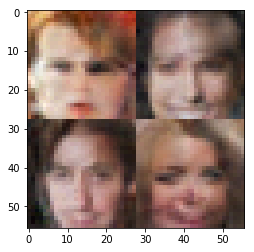

Epoch 1/1... Discriminator Loss: 1.9752... Generator Loss: 0.2638
Epoch 1/1... Discriminator Loss: 0.8708... Generator Loss: 1.3937
Tensor("generator_215/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_215/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_215/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_215/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_216/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_216/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_216/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_216/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


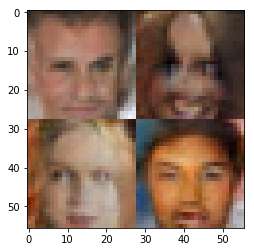

Epoch 1/1... Discriminator Loss: 1.6568... Generator Loss: 0.3886
Epoch 1/1... Discriminator Loss: 0.8190... Generator Loss: 1.3922
Tensor("generator_217/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_217/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_217/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_217/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_218/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_218/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_218/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_218/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


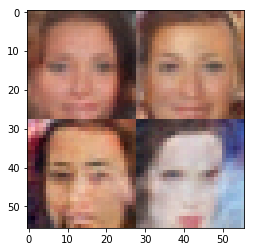

Epoch 1/1... Discriminator Loss: 0.6033... Generator Loss: 2.0620
Epoch 1/1... Discriminator Loss: 0.5496... Generator Loss: 1.9639
Tensor("generator_219/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_219/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_219/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_219/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_220/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_220/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_220/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_220/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


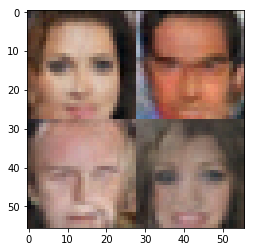

Epoch 1/1... Discriminator Loss: 0.6132... Generator Loss: 1.7015
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.6440
Tensor("generator_221/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_221/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_221/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_221/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_222/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_222/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_222/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_222/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


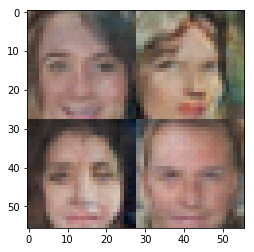

Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 0.9894... Generator Loss: 1.3892
Tensor("generator_223/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_223/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_223/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_223/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_224/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_224/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_224/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_224/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


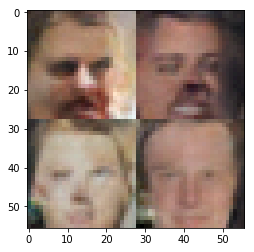

Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 0.8073... Generator Loss: 1.1014
Tensor("generator_225/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_225/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_225/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_225/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_226/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_226/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_226/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_226/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


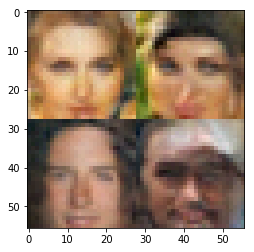

Epoch 1/1... Discriminator Loss: 0.9003... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 2.0741... Generator Loss: 0.2287
Tensor("generator_227/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_227/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_227/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_227/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_228/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_228/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_228/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_228/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


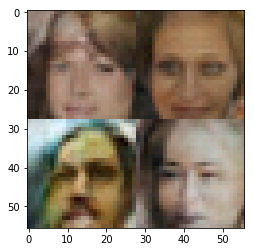

Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.5975
Tensor("generator_229/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_229/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_229/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_229/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_230/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_230/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_230/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_230/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


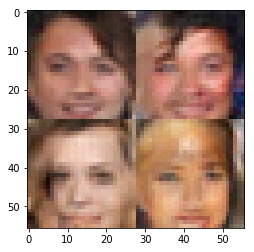

Epoch 1/1... Discriminator Loss: 0.7982... Generator Loss: 1.8031
Epoch 1/1... Discriminator Loss: 1.8853... Generator Loss: 0.3066
Tensor("generator_231/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_231/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_231/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_231/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_232/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_232/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_232/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_232/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


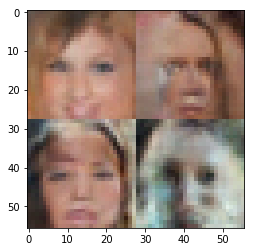

Epoch 1/1... Discriminator Loss: 1.5576... Generator Loss: 0.5114
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 0.8889
Tensor("generator_233/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_233/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_233/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_233/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_234/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_234/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_234/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_234/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


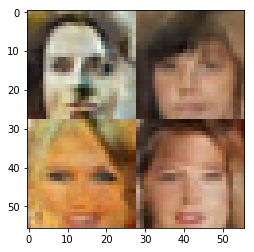

Epoch 1/1... Discriminator Loss: 0.8651... Generator Loss: 1.1133
Epoch 1/1... Discriminator Loss: 0.8018... Generator Loss: 1.2384
Tensor("generator_235/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_235/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_235/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_235/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_236/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_236/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_236/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_236/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


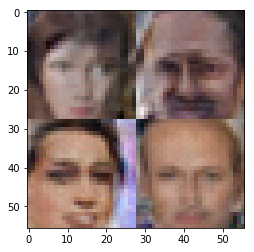

Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 0.9649... Generator Loss: 0.9169
Tensor("generator_237/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_237/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_237/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_237/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_238/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_238/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_238/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_238/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


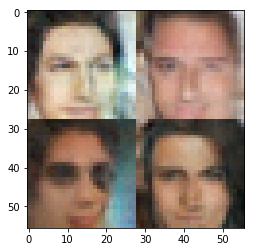

Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.5967
Tensor("generator_239/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_239/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_239/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_239/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_240/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_240/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_240/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_240/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


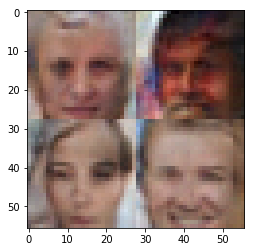

Epoch 1/1... Discriminator Loss: 1.8043... Generator Loss: 0.3067
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.6633
Tensor("generator_241/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_241/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_241/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_241/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_242/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_242/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_242/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_242/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


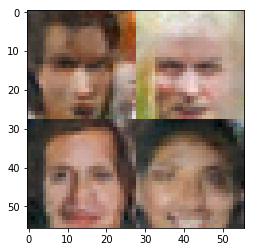

Epoch 1/1... Discriminator Loss: 0.9401... Generator Loss: 1.4752
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.6735
Tensor("generator_243/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_243/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_243/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_243/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_244/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_244/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_244/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_244/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


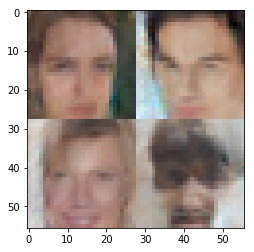

Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.5618
Tensor("generator_245/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_245/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_245/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_245/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_246/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_246/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_246/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_246/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


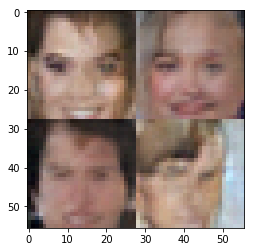

Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 1.1192
Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 1.1135
Tensor("generator_247/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_247/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_247/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_247/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_248/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_248/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_248/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_248/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


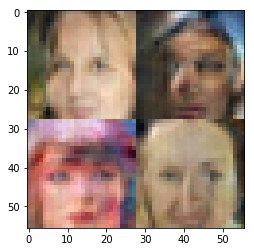

Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.7329... Generator Loss: 0.3377
Tensor("generator_249/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_249/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_249/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_249/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_250/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_250/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_250/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_250/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


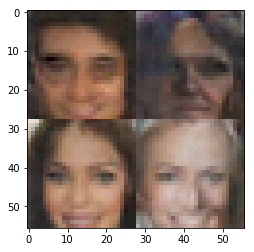

Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.7272
Tensor("generator_251/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_251/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_251/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_251/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("generator_252/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator_252/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator_252/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator_252/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)


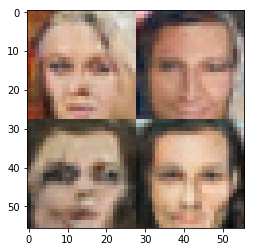

Epoch 1/1... Discriminator Loss: 0.8599... Generator Loss: 1.0575


In [15]:
batch_size = 16  #Try reducing batch_size to (~16 to 32)
z_dim = 100
learning_rate = 0.0005  #DCGAN with this architectural structure remains stable with lr between 0.0001 and 0.0008
beta1 = 0.5  #The beta1 is too high. Values like 0.3 to 0.5 have shown to get best results.


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.